ctrl shift f10 - search commands

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib


In [2]:
from tensorflow import keras
from tensorflow.keras import activations, regularizers, layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


In [4]:
filetype = "Segmented"
diseasename = "Isariopsis"
numcode = 1

# Getting the data

terminate session - ram disk 3 dots, manage session, terminate

In [5]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [6]:
!unzip '/content/gdrive/MyDrive/Plants Project/Plants_T_GHL.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Plants_T_GHL/Train/Apple/Apple scab/66__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/67__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/68__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/69__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/7__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/70__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/71__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/72__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/73__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/74__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/75__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/76__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/

# temp - count

In [7]:
xpath = '/content/Plants_T_GHL/Train/Grapes' + '/Healthy/No label'
data_dir = pathlib.Path(xpath)
print(len(list(data_dir.glob('*'))))


380


In [8]:
xpath = '/content/Plants_T_GHL/Train/Grapes/'+ diseasename 


In [9]:
import os
c = 0
for folder, subfolders, filenames in os.walk(xpath):
    c += len(filenames)
print(c)

380


# Some functions

In [10]:
def get_label(file_path, class_names):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The fourth to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)



In [11]:
def decode_img(img, img_height, img_width):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


In [12]:
def process_path(file_path):
  label = get_label(file_path, class_names)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img, img_height, img_width)
  return img, label


In [13]:
def getfiles(srcpath):
  lfiles = []
  for fol, subfol, files in os.walk(srcpath):
    for file in files:
      lfiles.append(os.path.join(srcpath, os.path.relpath(file)))
  return lfiles

In [14]:
def getinput(src, image_count):
  list_ds = tf.data.Dataset.list_files(str(src), shuffle=True)
  list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)
  val_size = int(image_count * 0.2)
  print(src, 'val size', val_size)
  train_ds = list_ds.skip(val_size)
  val_ds = list_ds.take(val_size)
  print(src, '# train', tf.data.experimental.cardinality(train_ds).numpy())
  print(src, '# test', tf.data.experimental.cardinality(val_ds).numpy())


In [15]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [16]:
def pred(imgpath):
  img = tf.keras.utils.load_img(
      os.path.abspath(imgpath), target_size=(img_height, img_width, 3)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = head_model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      " {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )
  return class_names[np.argmax(score)]

In [17]:
def test_acc(srcpath, classlabel):
  c = 0
  for i in srcpath:
    # print(i, pred(i), classlabel)
    if classlabel == pred(i):
      c += 1
  return c

# Some parameters

In [18]:
batch_size = 32
img_height = 229
img_width = 229


In [19]:
xpath = '/content/Plants_T_GHL/Train/Grapes/'+ diseasename 
data_dir = pathlib.Path(xpath)
print(len(list(data_dir.glob('*'))))


2


# Preparing data

In [20]:
image_count = 190 * 2
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=True)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)

In [21]:
for f in list_ds.take(5):
  print(f.numpy())


b'/content/Plants_T_GHL/Train/Grapes/Isariopsis/High/32__Segmented__Isariopsis__High.JPG'
b'/content/Plants_T_GHL/Train/Grapes/Isariopsis/Low/187__Segmented__Isariopsis__Low.JPG'
b'/content/Plants_T_GHL/Train/Grapes/Isariopsis/Low/19__Segmented__Isariopsis__Low.JPG'
b'/content/Plants_T_GHL/Train/Grapes/Isariopsis/High/146__Segmented__Isariopsis__High.JPG'
b'/content/Plants_T_GHL/Train/Grapes/Isariopsis/Low/162__Segmented__Isariopsis__Low.JPG'


In [22]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)


['High' 'Low']


In [23]:
val_size = int(image_count * 0.2)
print(val_size)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)


76


In [24]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.SkipDataset'>


In [25]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


304
76


# Standardize the data

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(buffer_size= image_count )
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [28]:
height_factor = [0, 0.2] # between 20%, 30%
width_factor = [0, 0.2]
layer_zoom = tf.keras.layers.RandomZoom(
    height_factor, width_factor=None, fill_mode='reflect',
    interpolation='bilinear', seed=None, fill_value=0.0
)
train_ds = train_ds.map(lambda x, y: (layer_zoom(x), y))
val_ds = val_ds.map(lambda x, y: (layer_zoom(x), y))

factor = [0, 0.05]
layer_rot = tf.keras.layers.RandomRotation(
    factor, fill_mode='reflect', interpolation='bilinear',
    seed=None, fill_value=0.0
)
train_ds = train_ds.map(lambda x, y: (layer_rot(x), y))
val_ds = val_ds.map(lambda x, y: (layer_rot(x), y))



In [29]:
layer_train = tf.keras.layers.experimental.preprocessing.Normalization(axis=None)
train_ds = train_ds.map(lambda x, y: (layer_train(x), y))
val_ds = val_ds.map(lambda x, y: (layer_train(x), y))

In [30]:
for image, label in train_ds.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (229, 229, 3)
Label:  0
Image shape:  (229, 229, 3)
Label:  0
Image shape:  (229, 229, 3)
Label:  1
Image shape:  (229, 229, 3)
Label:  1
Image shape:  (229, 229, 3)
Label:  1


# Model

In [31]:
base_model = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False, weights='imagenet', classes=class_names, input_shape = (img_height, img_width, 3)
)

# tf.keras.applications.efficientnet.EfficientNetB1(
#     include_top=True, weights='imagenet', input_tensor=None,
#     input_shape=None, pooling=None, classes=1000,
#     classifier_activation='softmax', **kwargs
# )


27033600/27018416 [==============================] - 0s 0us/step


In [32]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(len(class_names), activation = 'softmax')(x)

head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [33]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

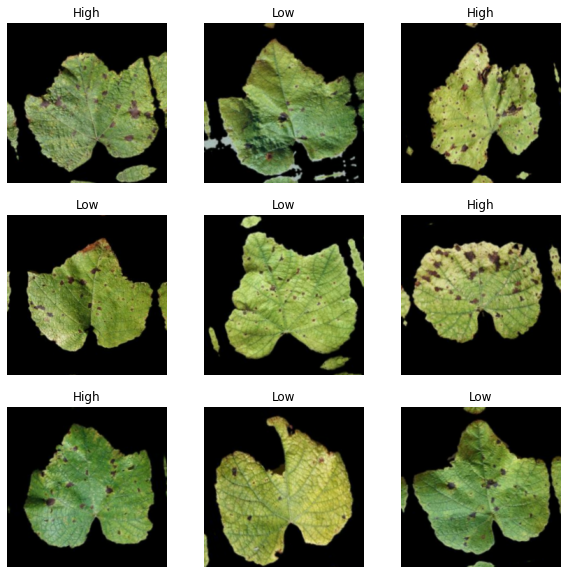

In [34]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")


# Train

In [35]:
epochs=50
history = head_model.fit(train_ds, batch_size = batch_size, epochs=epochs, validation_data=val_ds)

Epoch 1/50
10/10 [==============================] - 35s 1s/step - loss: 13.2236 - accuracy: 0.5822 - val_loss: 0.6225 - val_accuracy: 0.6447
Epoch 2/50
10/10 [==============================] - 5s 496ms/step - loss: 0.3256 - accuracy: 0.8914 - val_loss: 0.4937 - val_accuracy: 0.8289
Epoch 3/50
10/10 [==============================] - 5s 501ms/step - loss: 0.1740 - accuracy: 0.9375 - val_loss: 0.5707 - val_accuracy: 0.6579
Epoch 4/50
10/10 [==============================] - 5s 496ms/step - loss: 0.2136 - accuracy: 0.9671 - val_loss: 0.6154 - val_accuracy: 0.7632
Epoch 5/50
10/10 [==============================] - 5s 500ms/step - loss: 0.1078 - accuracy: 0.9507 - val_loss: 3.4347 - val_accuracy: 0.4868
Epoch 6/50
10/10 [==============================] - 5s 501ms/step - loss: 0.1116 - accuracy: 0.9638 - val_loss: 3.6769 - val_accuracy: 0.5395
Epoch 7/50
10/10 [==============================] - 5s 504ms/step - loss: 0.0594 - accuracy: 0.9704 - val_loss: 3.1873 - val_accuracy: 0.5789
Epoch 8

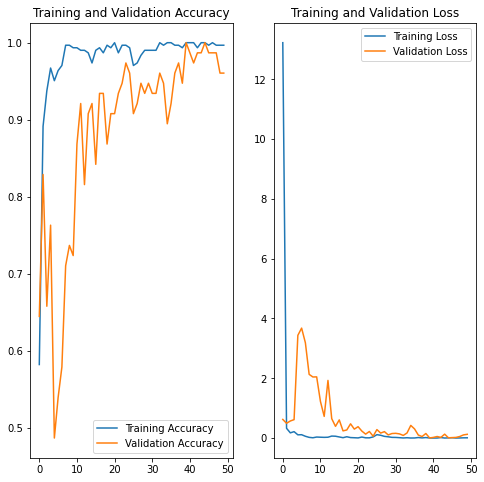

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [37]:
print(acc, val_acc)

[0.5822368264198303, 0.8914473652839661, 0.9375, 0.9671052694320679, 0.9506579041481018, 0.9638158082962036, 0.9703947305679321, 0.9967105388641357, 0.9967105388641357, 0.9934210777282715, 0.9934210777282715, 0.9901315569877625, 0.9901315569877625, 0.9868420958518982, 0.9736841917037964, 0.9901315569877625, 0.9934210777282715, 0.9868420958518982, 0.9967105388641357, 0.9934210777282715, 1.0, 0.9868420958518982, 0.9967105388641357, 0.9967105388641357, 0.9934210777282715, 0.9703947305679321, 0.9736841917037964, 0.9835526347160339, 0.9901315569877625, 0.9901315569877625, 0.9901315569877625, 0.9901315569877625, 1.0, 0.9967105388641357, 1.0, 1.0, 0.9967105388641357, 0.9967105388641357, 0.9934210777282715, 1.0, 1.0, 1.0, 0.9934210777282715, 1.0, 1.0, 0.9967105388641357, 1.0, 0.9967105388641357, 0.9967105388641357, 0.9967105388641357] [0.6447368264198303, 0.8289473652839661, 0.6578947305679321, 0.7631579041481018, 0.4868420958518982, 0.5394737124443054, 0.5789473652839661, 0.7105262875556946, 

# Save and load methods

In [38]:
head_model.save('/content/gdrive/MyDrive/Plants Project/'+ 'eff_'+ diseasename + "_HL_"+str(numcode) + '.h5')

In [39]:
head_model.save_weights('/content/gdrive/MyDrive/Plants Project/my_checkpoint/'+ diseasename + "/" +'eff_HL_' +str(numcode) )

# Test

In [40]:
class_names = ["High", "Low"]
base_model = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False,
    weights="imagenet",
    classes=class_names,
    input_shape=(img_height, img_width, 3),
)
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation="relu")(x)
predictions = layers.Dense(len(class_names), activation="softmax")(x)

head_model = Model(inputs=base_model.input, outputs=predictions)
head_model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [41]:
head_model.load_weights('/content/gdrive/MyDrive/Plants Project/my_checkpoint/'+ diseasename + "/" +'eff_HL_' +str(numcode) )

In [42]:
severity = ['Low', 'High']
filesdict = {}
for sev in severity:
  # Plants_T_GHL/Train/Grapes/Isariopsis/Low
  srcpath = r'/content/Plants_T_GHL/Test/Grapes/'+diseasename+"/"+ sev
  # print(getfiles(srcpath))
  filesdict[diseasename+sev] = [sev, getfiles(srcpath)]

In [43]:
for k, v in filesdict.items():
  count_ = test_acc(v[1], v[0])
  print(k, count_, count_/len(v))

 Low with a 73.11 percent confidence.
 Low with a 60.46 percent confidence.
 Low with a 68.50 percent confidence.
 Low with a 73.00 percent confidence.
 Low with a 57.75 percent confidence.
 Low with a 73.10 percent confidence.
 Low with a 73.11 percent confidence.
 Low with a 72.24 percent confidence.
 Low with a 68.45 percent confidence.
 High with a 71.51 percent confidence.
 Low with a 72.88 percent confidence.
 High with a 72.81 percent confidence.
 Low with a 73.08 percent confidence.
 High with a 72.60 percent confidence.
 Low with a 73.10 percent confidence.
 Low with a 73.08 percent confidence.
 Low with a 73.11 percent confidence.
 High with a 51.21 percent confidence.
 Low with a 72.04 percent confidence.
 Low with a 70.39 percent confidence.
IsariopsisLow 16 8.0
 High with a 72.64 percent confidence.
 High with a 73.11 percent confidence.
 High with a 73.11 percent confidence.
 High with a 73.10 percent confidence.
 High with a 72.96 percent confidence.
 High with a 73.11 p

In [44]:
!tar -czvf HL_Isariopsis_1_Segmented.tar.gz  '/content/checkpoints/HighLow/Isariopsis/'

tar: Removing leading `/' from member names
tar: /content/checkpoints/HighLow/Isariopsis: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


In [45]:
!tar -czvf HL_Isariopsis_1_Segmented.tar.gz  '/content/HL_Isariopsis_1_Segmented.h5'

tar: Removing leading `/' from member names
tar: /content/HL_Isariopsis_1_Segmented.h5: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


In [ ]:
# from google.colab import files
# files.download('final20modelDensenet.tar.gz')
# files.download('final20modelDensenet_h5.tar.gz')